https://support.zemax.com/hc/en-us/articles/4406838460819-Modelling-of-a-Shack-Hartmann-Sensor-for-eye-aberration-evaluation  
https://support.zemax.com/hc/en-us/articles/1500005575422-How-to-model-a-black-box-optical-system-using-Zernike-coefficients

Project to make data that matches our real image from ATLAS

In [51]:
import os 
import sys
import h5py
path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.insert(0,path)

import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
from skimage.restoration import unwrap_phase
from utils.api_functions import *
from utils.opt_functions import *
from shack_hartmann.sh_functions import *



%run -i "\\alfs1.physics.ox.ac.uk\al\howards\Zemax\ZOS-API Projects\PythonZOSConnection\PythonZOSConnection.py"
fast_system(TheSystem) # this speeds up the program.

Found OpticStudio at:   %sc:\program files\zemax opticstudio
Connected to OpticStudio
Serial #:  L121911


<Figure size 432x288 with 0 Axes>

We see that a peak consists of approx 5x5 squares

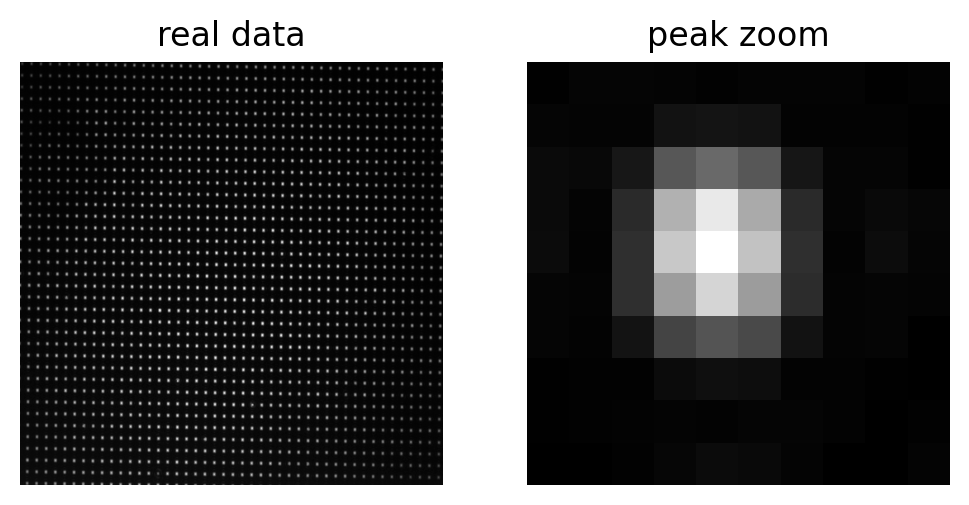

In [52]:
from skimage.transform import resize
Nx = 512

real = resize(plt.imread('ATLAS_shot_ex.png'),(Nx,Nx)) #resize as too big for me to process
fig,ax = plt.subplots(1,2, dpi =200)
ax[0].imshow(real,cmap='Greys_r');ax[0].set_title('real data');ax[0].set_axis_off()
ax[1].imshow(real[155:165,155:165],cmap='Greys_r');ax[1].set_title('peak zoom');ax[1].set_axis_off()

In [53]:
n_zernikes = 45
rotation_amount = -1
n_lens = 67
w_lens = 0.15 #(mm)
aperture_value = n_lens*w_lens #this is what im saying is the width of the laser. we will cut out of it later.
crop_size = 47*w_lens #our detector width
Nx = 512
peak_size = 0.2 #i dont really know what this means but it means the peaks have some width.


zernike_surf = TheSystem.LDE.GetSurfaceAt(1)
zernike_surf.SurfaceData.NumberOfTerms = n_zernikes
zernike_surf.SurfaceData.NormRadius = aperture_value

rotation_surf = TheSystem.LDE.GetSurfaceAt(5)
rotation_surf.SurfaceData.set_TiltAbout_Z(rotation_amount)
#
microlens_surf = TheSystem.LDE.GetSurfaceAt(4)
microlens_surf.SurfaceData.Par1.DoubleValue = n_lens
microlens_surf.SurfaceData.Par2.DoubleValue = n_lens #number of lens
microlens_surf.SurfaceData.Par3.DoubleValue = w_lens
microlens_surf.SurfaceData.Par4.DoubleValue = w_lens #lens width in mm

TheSystem.SystemData.Aperture.ApertureValue = aperture_value
TheSystem.SystemData.Aperture.ApodizationType = 1
TheSystem.SystemData.Aperture.ApodizationFactor = 1

TheSystem.SystemData.Wavelengths.GetWavelength(1).Wavelength = 0.760


In [54]:
# Generate abberations
main_aberration = np.round(n_zernikes*np.random.rand(1))
# design aberrations not enrirely random but to lie around a main aberration
zernike_coeffs = np.random.rand(n_zernikes)/(1+np.abs(np.arange(0,n_zernikes,1)-main_aberration))**(2*np.random.rand(1))


set_zernikes(ZOSAPI, zernike_surf, n_zernikes,zernike_coeffs)

In [55]:
image = get_spots(ZOSAPI,TheSystem,Nx,rays=30,imagesize=crop_size,fieldsize = peak_size) # get spot pattern
wavefront = get_wavefront(ZOSAPI,TheSystem,Nx) # get wavefront

Prove its proportional to the LightPipes one...

In [56]:
new_coeffs = rot_zern_coeffs(old_coeffs = zernike_coeffs,rotation_deg = 180)
N = Nx
size = N * 150*lp.um
λ  = 750*lp.nm
F=lp.Begin(size,λ  ,N) # initiate


for Noll in range(1, n_zernikes+1):
        (nz, mz) = lp.noll_to_zern(Noll) #converting between int and zernike coeffs
        e_m = 2 if mz == 0 else 1
        A = 1
        F = lp.Zernike(F, nz, mz, size, new_coeffs[Noll-1] * A, units='lam')

F_ideal=lp.CircAperture(F,size/2)

wavefront2 = unwrap_phase(np.angle(F_ideal.field))


x, y  = np.linspace(-1,1,N),np.linspace(-1,1,N)

xx,yy = np.meshgrid(x,y)
r = np.sqrt(xx**2 + yy**2)
wavefront2[r>1] = 0

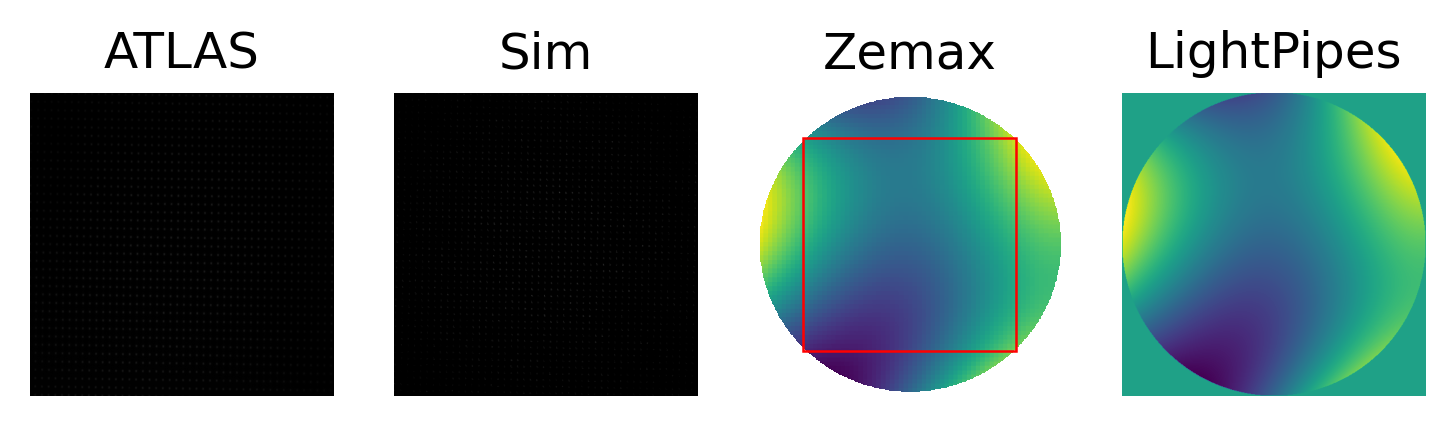

In [59]:
import matplotlib.patches as patches



%matplotlib inline
fig,ax = plt.subplots(1,4,dpi=300)
ax[0].imshow(real,cmap='Greys_r',vmax = 5);ax[0].set_title('ATLAS');ax[0].set_axis_off()
ax[1].imshow(image,cmap='Greys_r',vmax = 50);ax[1].set_title('Sim');ax[1].set_axis_off()
ax[2].imshow(wavefront);ax[2].set_title('Zemax');ax[2].set_axis_off()
ax[3].imshow(wavefront2);ax[3].set_title('LightPipes');ax[3].set_axis_off()

#in reality we're only gunna see the amount of wavefront inside the 'crop_size'
factor = crop_size/aperture_value

ax[2].add_patch(
     patches.Rectangle(
        ((1-factor)*Nx/2, (1-factor)*Nx/2),
        factor*Nx,
        factor*Nx,
        fill=False,      # remove background
        edgecolor='r',
        linewidth=0.6
     ) ) 
